In [1]:
import matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn.metrics as sk_metrics
from matplotlib import pyplot as plt
import tempfile
import os
import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

tf.random.set_seed(22)

In [3]:
def preprocess(x, y):
    x = tf.reshape(x, shape=[-1, 784])
    x = x / 255
    return x, y


def xavier_init(shape):
    in_dim, out_dim = shape
    xavier_lim = tf.sqrt(6.) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    weight_vals = tf.random.uniform(shape=(in_dim, out_dim), minval=-xavier_lim, maxval=xavier_lim, seed=22)
    return weight_vals

In [4]:
class DenseLayer(tf.Module):
    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        super().__init__()
        self.out_dim = out_dim
        self.weight_init = weight_init
        self.activation = activation
        self.built = False

    def __call__(self, x):
        if not self.built:
            self.in_dim = x.shape[1]
            self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
            self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
            self.built = True
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)

In [5]:
class ExportModule(tf.Module):
    def __init__(self, model, preprocess, class_pred):
        super().__init__()
        self.model = model
        self.preprocess = preprocess
        self.class_pred = class_pred

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)])
    def __call__(self, x):
        x = self.preprocess(x)
        y = self.model(x)
        y = self.class_pred(y)
        return y

In [6]:
class MLP(tf.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    @tf.function
    def __call__(self, x, preds=False):
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
class Adam:
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.learning_rate = learning_rate
        self.ep = ep
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(self.beta_1 * self.v_dvar[i] + (1 - self.beta_1) * d_var)
            self.s_dvar[i].assign(self.beta_2 * self.s_dvar[i] + (1 - self.beta_2) * tf.square(d_var))
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1 ** self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2 ** self.t))
            var.assign_sub(self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.ep)))
        self.t += 1.
        return

In [8]:
def cross_entropy_loss(y_pred, y):
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)


def accuracy(y_pred, y):
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
    is_equal = tf.equal(y, class_preds)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    grads = tape.gradient(batch_loss, model.variables)
    optimizer.apply_gradients(grads, model.variables)
    return batch_loss, batch_acc


def val_step(x_batch, y_batch, loss, acc, model):
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc


def preprocess_test(x):
    x = tf.reshape(x, shape=[-1, 784])
    x = x / 255
    return x


def class_pred_test(y):
    return tf.argmax(tf.nn.softmax(y), axis=1)

In [9]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        for x_batch, y_batch in train_data:
            batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
        val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
        print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
    return train_losses, train_accs, val_losses, val_accs

In [10]:
def plot_metrics(train_metric, val_metric, metric_type):
    plt.figure()
    plt.plot(range(len(train_metric)), train_metric, label=f"Training {metric_type}")
    plt.plot(range(len(val_metric)), val_metric, label=f"Validation {metric_type}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_type)
    plt.legend()
    plt.title(f"{metric_type} vs Training epochs")
    plt.show()


def accuracy_score(y_pred, y):
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


def show_confusion_matrix(test_labels, test_classes):
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1)
    axis_labels = range(10)
    ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [48]:
train_data, val_data, test_data = tfds.load("mnist", split=['train[10000:]', 'train[0:10000]', 'test'], batch_size=128, as_supervised=True, shuffle_files=True)
train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [46]:
epochs = 5

In [47]:
output_size = 10

In [17]:
mlp_model_A = MLP([
        DenseLayer(out_dim=700, activation=tf.nn.relu),
        DenseLayer(out_dim=500, activation=tf.nn.relu),
        DenseLayer(out_dim=output_size)])

In [20]:
mlp_model_B = MLP([
        DenseLayer(out_dim=256, activation=tf.nn.relu),
        DenseLayer(out_dim=output_size)])

In [49]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model_B, train_data, val_data, loss=cross_entropy_loss, acc=accuracy, optimizer=Adam(), epochs=epochs)

Epoch: 0
Training loss: 0.004, Training accuracy: 0.999
Validation loss: 0.106, Validation accuracy: 0.980
Epoch: 1
Training loss: 0.002, Training accuracy: 1.000
Validation loss: 0.106, Validation accuracy: 0.981
Epoch: 2
Training loss: 0.004, Training accuracy: 0.999
Validation loss: 0.137, Validation accuracy: 0.976
Epoch: 3
Training loss: 0.003, Training accuracy: 0.999
Validation loss: 0.109, Validation accuracy: 0.980
Epoch: 4
Training loss: 0.001, Training accuracy: 1.000
Validation loss: 0.105, Validation accuracy: 0.982


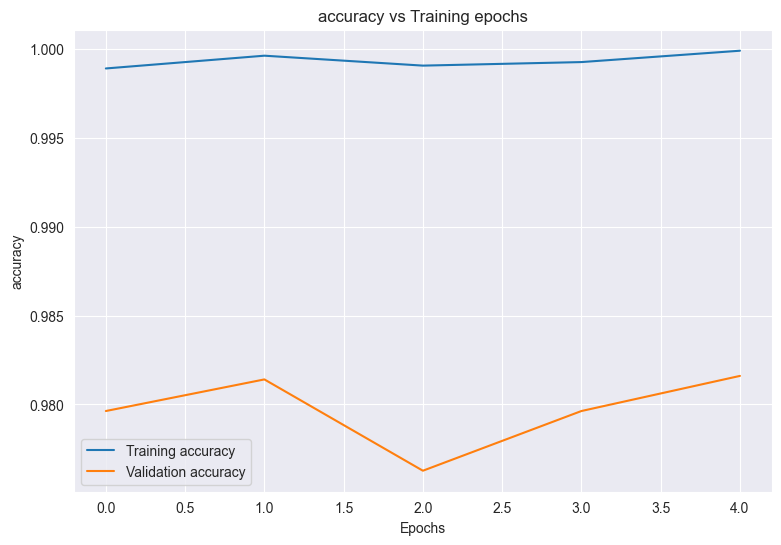

In [50]:
plot_metrics(train_accs, val_accs, "accuracy")

In [51]:
mlp_model_export = ExportModule(model=mlp_model_B, preprocess=preprocess_test, class_pred=class_pred_test)

In [52]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: C:\Users\vinic\AppData\Local\Temp\tmp__2k6rie\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\vinic\AppData\Local\Temp\tmp__2k6rie\mlp_model_export\assets


In [53]:
mlp_loaded = tf.saved_model.load(save_path)

In [54]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)

In [56]:
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.980


In [57]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
    label_ind = (y_test == label)
    pred_label = test_classes[label_ind]
    label_filled = tf.cast(tf.fill(pred_label.shape[0], label), tf.int64)
    label_accs[accuracy_score(pred_label, label_filled).numpy()] = label
for key in sorted(label_accs):
    print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.972
Digit 2: 0.973
Digit 8: 0.974
Digit 5: 0.975
Digit 9: 0.978
Digit 3: 0.978
Digit 4: 0.983
Digit 6: 0.983
Digit 0: 0.991
Digit 1: 0.992


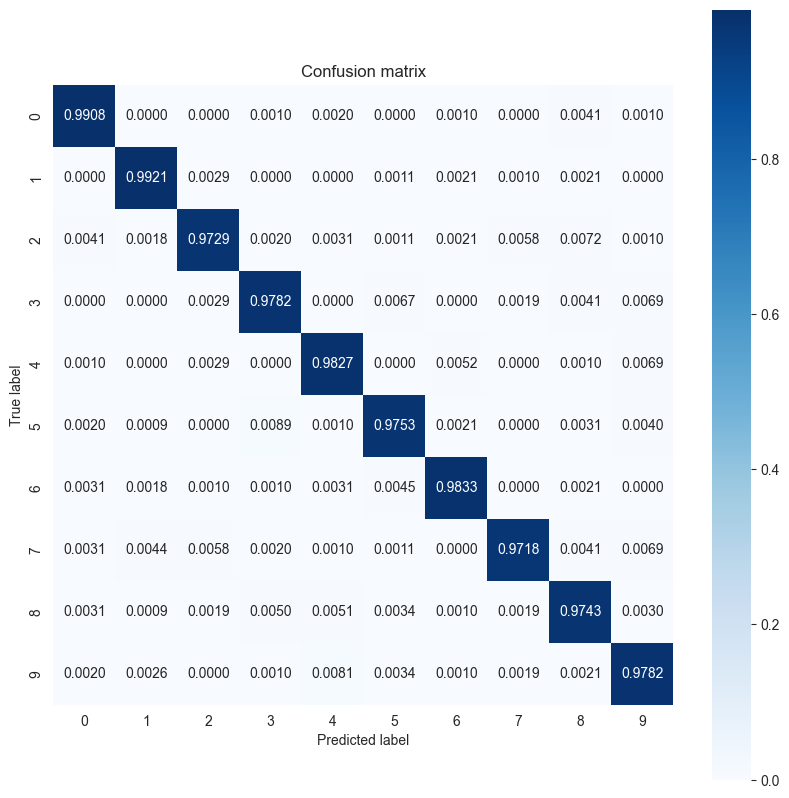

In [58]:
show_confusion_matrix(y_test, test_classes)